In [1]:
import os
import numpy as np
#import pickle
%matplotlib inline
from matplotlib import pyplot as plt
#import seaborn as sns
import tensorflow as tf
from skimage.filters import sobel_h, sobel_v
from skimage.color import rgb2grey
from skimage.transform import resize
from skimage.filters import threshold_adaptive
from skimage.exposure import rescale_intensity
from utils.utils import *
from utils.iterators import SynthiaIterator, FreiburgIterator, TUMIterator
from utils.associate import associate, read_file_list
import tensorflow as tf
from tqdm import tqdm
from random import shuffle
import random

from models import interpolation_model

D:\Python36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
#All paths are here
#synthia_dataset = '/home/vladimir/external/data/SYNTHIA/SYNTHIA-SEQS-02-SOFTRAIN/'
synthia_dataset = 'D:/Alice/Documents/depth_datasets/SYNTHIA/'
synthia_val = 'D:/Alice/Documents/depth_datasets/SYNTHIA/SYNTHIA-SEQS-05-SPRING/'

synthia_size=(480,  640)

log_prefix = 'D:/Alice/Documents/deeplearning-semidense/out/test'

vgg_npy_path = 'vgg/vgg16.npy'

In [3]:
synthia_list = get_file_list(synthia_dataset)
synthia_val_list = get_file_list(synthia_val)
synthia_list = [f for f in synthia_list if f not in synthia_val_list]

synthia_depth = filter_files(synthia_list, ['Stereo_Left', 'Depth', 'png'])
synthia_rgb =  filter_files(synthia_list, ['Stereo_Left','RGB','png'])

In [4]:
synthia_depth_val = filter_files(synthia_val_list, ['Stereo_Left', 'Depth', 'png'])
synthia_rgb_val = filter_files(synthia_val_list, ['Stereo_Left', 'RGB', 'png'])

In [5]:
val_image_s = open_rgb(synthia_rgb_val[0])[None,:,:,:]
val_gt_s = open_depth_synthia(synthia_depth_val[0], debug=True)[None]
val_image_d = open_rgb(synthia_rgb_val[-1])[None,:,:,:]
val_gt_d = open_depth_synthia(synthia_depth_val[-1])[None,:,:,:]

print('Train size', len(synthia_rgb))
print('Validation size', len(synthia_rgb_val))

(760, 1280)
uint16
Train size 12972
Validation size 1180


In [78]:
def augment_data(img, depth):
    coin = tf.less(tf.random_uniform([], 0, 1.0), 0.5)
    seed = random.random()
    img = tf.cond(coin, lambda: tf.image.random_flip_left_right(img, seed = seed), 
                  lambda: tf.image.random_flip_up_down(img, seed=seed))
    depth = tf.cond(coin, lambda: tf.image.random_flip_left_right(depth, seed = seed), 
                  lambda: tf.image.random_flip_up_down(depth, seed=seed))
    return img, depth

In [79]:
def input_parser(rgb_img_path, depth_path, size = synthia_size):
    # read the img from file
    img_file = tf.read_file(rgb_img_path)
    img_decoded = tf.image.decode_image(img_file, channels=3)
    img_decoded.set_shape([None, None, 3])
    image_resized = tf.image.resize_images(img_decoded, size)
    
    depth_file = tf.read_file(depth_path)
    depth_decoded = tf.image.decode_image(depth_file, channels=1)
    depth_decoded.set_shape([None, None, 1])
    depth_resized = tf.image.resize_images(depth_decoded, size)
    
    image_resized, depth_resized = augment_data(image_resized, depth_resized) 

    return image_resized, depth_resized



In [153]:
tf.reset_default_graph()

In [154]:

batch_size = 5
input_size = synthia_size#tf.placeholder(tf.int32, shape = (1,2))

with tf.device('/cpu:0'):
    tr_data = tf.data.Dataset.from_tensor_slices((synthia_rgb,synthia_depth))
    tr_data = tr_data.shuffle(buffer_size=512)
    tr_data = tr_data.map(lambda x,y: input_parser(x,y, input_size))
    tr_data = tr_data.batch(batch_size = batch_size)


    val_data = tf.data.Dataset.from_tensor_slices((synthia_rgb_val,synthia_depth_val))
    val_data = val_data.map(lambda x,y: input_parser(x,y, input_size))
    val_data = val_data.batch(batch_size = batch_size)


    iterator = tf.data.Iterator.from_structure(tr_data.output_types, tr_data.output_shapes)

    next_element_rgb, next_element_d  = iterator.get_next()
    next_element_rgb, next_element_d 
    print(next_element_rgb.shape, next_element_d.shape )

    training_init_op = iterator.make_initializer(tr_data)
    validation_init_op = iterator.make_initializer(val_data)

(?, 480, 640, 3) (?, 480, 640, 1)


In [140]:
with tf.Session() as sess:

    # initialize the iterator on the training data
    sess.run(training_init_op)

    # get each element of the training dataset until the end is reached
    i = 0
    while i<5:
        try:
           
            elem = sess.run(next_element)
            plt.imshow(elem[0][1,:,:,:]/255)
            plt.matshow(elem[1][1,:,:,0])
            print(elem[0].shape)
            plt.figure()
            i+=1
        except tf.errors.OutOfRangeError:
            print("End of training dataset.")
            break

ValueError: Fetch argument <tf.Tensor 'IteratorGetNext:0' shape=(?, 480, 640, ?) dtype=float32> cannot be interpreted as a Tensor. (Tensor Tensor("IteratorGetNext:0", shape=(?, 480, 640, ?), dtype=float32) is not an element of this graph.)

In [141]:
def preprocess_depth(d_tensor, mask_tensor, size):
    eps = tf.constant(1e-2)
    maxi = tf.constant(1e4)

    d_cl = tf.clip_by_value(d_tensor, eps, maxi)
    d_log = tf.log(d_cl + 1.)
    
    masked = ground_truth * mask_tensor[:, :]
    nonzero = tf.cast(tf.count_nonzero(masked, axis=(1, 2), keep_dims=True), tf.float32)
    masked_sum = tf.reduce_sum(masked, axis=(1, 2), keep_dims=True)
    mean_d = masked_sum / nonzero
    
    masked_centered = masked - mean_d

    return ground_truth, masked_centered, mean_d


def preprocess_rgb(rgb_tensor, size):
    greyscale = rgb_res[:, :, :, 0] * 0.2989 + rgb_res[:, :, :, 1] * 0.5870 + rgb_res[:, :, :, 2] * 0.1140
    greyscale = greyscale[:, :, :, None]
    g_min = tf.reduce_min(greyscale, axis=(1, 2), keep_dims=True)
    g_max = tf.reduce_max(greyscale, axis=(1, 2), keep_dims=True)
    g_normed = (greyscale - g_min) / (g_max - g_min)
    g_out = g_normed - tf.reduce_mean(g_normed, axis=(1, 2), keep_dims=True)

    return g_out

In [142]:
def threshold_mask(img, sz, t):
    img_rescaled = ((img - img.min(axis=(0,1)))/(img.max(axis=(0,1)) - img.min(axis=(0,1))) - 0.5)*2
    grey = rgb2grey(img_rescaled) 
    grey_resized = resize(grey, sz, preserve_range=True)
    grad = np.sqrt(sobel_h(grey_resized)**2 + sobel_v(grey_resized)**2)
    thr = threshold_adaptive(grad, t, method='mean')
    return thr.astype(int)[None, :,:, None]

def combined_mask(img, sz, combined=True):
    import cv2
    resized = cv2.resize(img.astype(np.uint8), tuple(sz[::-1]))
    blurred = cv2.GaussianBlur(resized, (5, 5), 0.2)
    grey = cv2.cvtColor(blurred, cv2.COLOR_RGB2GRAY)
    grad_x = cv2.Sobel(grey, cv2.CV_16S, 1, 0).astype(float)
    grad_y = cv2.Sobel(grey, cv2.CV_16S, 0, 1).astype(float)
    grad = np.sqrt(np.square(grad_x) + np.square(grad_y))
    grad = np.round((grad - grad.min())/(grad.max() - grad.min())*255).astype(np.uint8)
    grad_thr = cv2.adaptiveThreshold(grad,np.max(grad),cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 5, 11
                                    )
    grad_thr = (grad_thr - grad_thr.min())/(grad_thr.max() - grad_thr.min())
    grad_thr = np.ones(grad_thr.shape, dtype=np.float32) - grad_thr.astype(np.float32) 
    random = np.random.choice([0, 1],size=sz, p=[1 - 0.05, 0.05])
    if combined:
        grad_thr = np.clip(grad_thr + random, 0, 1)
    else:
        grad_thr = np.clip(grad_thr, 0, 1)
    return grad_thr.astype(int)[None, :, :, None]


def get_grad_mask(img, sz, combined=True, t=57):
    shape = img.shape
    bs = img.shape[0]
    #return np.concatenate([threshold_mask(img[i,:,:,:], sz,t) for i in range(bs)])
    return np.concatenate([combined_mask(img[i,:,:,:], sz, combined=combined) for i in range(bs)])

def get_mask(sz, p):

    mask = np.random.choice([0,1],size=sz, p=[1 - p, p])[None,:,:,None]
    return mask


def get_regular_grid_mask(sz, step = 7):
    z = np.zeros((1, *sz, 1))
    z[:,::step,::step,:] = 1
    return z

def predict(sess, G_output, batch_d, batch_mask):
    predicted = sess.run(G_output, feed_dict={target: batch_d, mask_t: batch_mask, d_flg: False})
    
    return predicted

def predict_sparse(sess, G_output, batch_d):
    predicted = sess.run(G_output, feed_dict={sparse: batch_d, d_flg: False})
    
    return predicted

In [143]:
def random_type_mask(rgb, size = synthia_size, mtype = 'rand'):
    if mtype == 'rand+grad':
        u = np.random.choice([0, 1], size=1000, p=[.3, .7])
        if u: 
            mtype = 'rand'
        else:
            mtype = 'grad'
                
    if mtype == 'rand':
        p = np.random.choice([0.05, 0.1, 0.2, 0.4])
        mask = get_mask(size, p)
    elif mtype == 'grad':
        mask = get_grad_mask(rgb, size)
    
    return mask
    

0.11817708333333334
0.148564453125


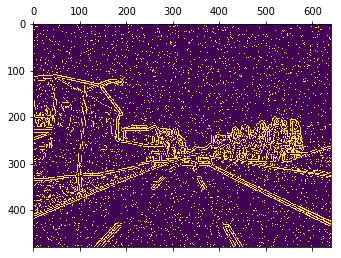

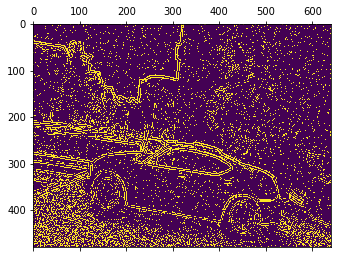

In [144]:
grad_ms = get_grad_mask(val_image_s,synthia_size)
grad_md = get_grad_mask(val_image_d,synthia_size)
plt.matshow(get_grad_mask(val_image_s,synthia_size)[0,:,:,0])
plt.matshow(get_grad_mask(val_image_d,synthia_size)[0,:,:,0])
print(np.mean(grad_ms))
print(np.mean(grad_md))

In [155]:
input_rgb, target,mask_t, d_flg = interpolation_model.get_placeholders()
with tf.device('/cpu:0'):
    input_rgb, target = next_element_rgb, next_element_d 
    mask_t = random_type_mask(input_rgb, mtype = 'rand')
    y_true, d_input, m = interpolation_model.preprocess_depth(target, mask_t, synthia_size)
    gr_input = interpolation_model.preprocess_rgb(input_rgb, synthia_size)
G_output =  interpolation_model.model(d_input, m, base_filters = 32,p=0.5, d_flg = False, use_bn = False)

In [156]:
#from vgg.vgg16 import VGG16
#vgg_model_true = VGG16(vgg19_npy_path=vgg_npy_path)
#vgg_model_gen = VGG16(vgg19_npy_path=vgg_npy_path)

In [157]:
with tf.variable_scope('loss'):
    #vgg loss
    #exp_out = tf.exp(G_output)
    #exp_true = tf.exp(y_true)
    exp_out = G_output
    exp_true = y_true
    y_true_normalized = (exp_true - tf.reduce_min(exp_true))/(tf.reduce_max(exp_true) 
                                                              - tf.reduce_min(exp_true))
    y_true_3ch = tf.concat([y_true_normalized]*3,3)
    
    gen_normalized = (exp_out - tf.reduce_min(exp_out))/(tf.reduce_max(exp_out) 
                                                         - tf.reduce_min(exp_out))
    gen_normalized = (exp_out - tf.reduce_min(exp_out))/(tf.reduce_max(exp_out) 
                                                         - tf.reduce_min(exp_out))
    generated_3ch = tf.concat([gen_normalized]*3, 3)
    
    """
    vgg_model_true.build(y_true_3ch)
    true_features = vgg_model_true.conv3_1
    vgg_model_gen.build(generated_3ch)
    gen_features = vgg_model_gen.conv3_1
    VGG_loss = tf.reduce_mean(tf.square(true_features - gen_features))
    """

    #generator_loss
    tv_loss = tf.reduce_mean(tf.reduce_sum(tf.sqrt(tf.square(G_output[:, :-1, -1:, :] - G_output[:, 1:, -1:, :]) + \
              tf.square(G_output[:, :-1, :-1, :] - G_output[:, :-1, 1:, :])), axis=[1, 2, 3]))
    #G_loss = tf.reduce_mean(tf.square(y_true - G_output)) 
    square_loss = tf.reduce_mean(tf.square(y_true - G_output))
    G_loss = square_loss# + 5e-5*VGG_loss
    #G_loss = tf.reduce_mean(tf.square(y_true - G_output)) + 2e-6*tv_loss
    #GC_loss = tf.reduce_mean(tf.abs(tf.log(GC_output  + eps) - log_true))

In [158]:
eps = tf.constant(1e-2)

In [159]:
with tf.variable_scope('opt'):
    #optimizers
    all_params = tf.trainable_variables()
    first_stage = [p for p in all_params if 'G_Depth' in p.name]
    lr = tf.placeholder(dtype=tf.float32)
    train_G = tf.train.AdamOptimizer(lr).minimize(G_loss, var_list = first_stage)

In [160]:
with tf.variable_scope('summaries'):
    loss = tf.summary.scalar('loss', G_loss)
    mae = tf.reduce_mean(tf.abs(G_output-y_true)/(y_true + eps))
    rmse = tf.sqrt(tf.reduce_mean(tf.square(G_output-y_true)))
    mae_summary = tf.summary.scalar('MAE', mae)
    in_summary = tf.summary.image('input', d_input , max_outputs=1)
    out_summary = tf.summary.image('output',G_output , max_outputs=1)
    gt_summary = tf.summary.image('gt_depth', y_true , max_outputs=1)
    all_summaries = tf.summary.merge([mae_summary, in_summary, out_summary, loss])

In [161]:
sess = tf.InteractiveSession()

ground_truths = tf.summary.FileWriter(logdir=os.path.join(log_prefix,'img_gt','s').replace("\\","/"))
ground_truthd = tf.summary.FileWriter(logdir=os.path.join(log_prefix, 'img_gt','d').replace("\\","/"))
writer_grads = tf.summary.FileWriter(logdir=os.path.join(log_prefix,'grad','s').replace("\\","/"))
writer_gradd = tf.summary.FileWriter(logdir=os.path.join(log_prefix,'grad','d').replace("\\","/"))
sess.run(tf.global_variables_initializer())

In [162]:
epochs = 1#35
n_batches= len(synthia_depth)/batch_size
"""
ground_truths.add_summary(gt_summary.eval({input_rgb:val_image_s, target:val_gt_s}))
ground_truthd.add_summary(gt_summary.eval({input_rgb:val_image_d, target:val_gt_d}))

"""
i = 0
rate =  [1e-4]*30 + [1e-5]*30 
saver = tf.train.Saver(max_to_keep=15)

for e in range(epochs):
    i = 0
    sess.run(training_init_op)
    mse_loss = 0
    
    for _ in range(100):
        _, ll = sess.run([train_G, G_loss], feed_dict = {d_flg:True, lr:rate[e]})
        mse_loss += ll
        i += 1
        print(i)
        """
            if (i + 1)%10 == 0:
                mask_uni = np.random.choice([0,1],size=synthia_size, p=[1 - 0.1, 0.1])[None,:,:,None]
                sum_grad = all_summaries.eval({input_rgb:val_image_s, target:val_gt_s, mask_t:grad_ms, d_flg:False})
                writer_grads.add_summary(sum_grad, i)
                sum_grad = all_summaries.eval({input_rgb:val_image_d, target:val_gt_d, mask_t:grad_md, d_flg:False})
                writer_gradd.add_summary(sum_grad, i)
        
        """
        
    sess.run(validation_init_op)
    for _ in range(100):
        sess.run(next_element)

"""

for e in range(epochs):
    try:
        val_loss = 0
        val_b = len(synthia_rgb_val)/batch_size
        batch_it = tqdm(SynthiaIterator(synthia_rgb_val, synthia_depth_val, 
                                        batchsize=batch_size, 
                                        shuffle=True, 
                                        buffer_size = 70), 
                        total=val_b, 
                        leave=False)

        for xb, yb in batch_it:
            #t = np.random.choice([21, 31, 51])
            mask = get_grad_mask(xb, synthia_size, 51)
            #p = np.random.choice([0.05, 0.1, 0.2, 0.4])
            #mask = get_mask(synthia_size, p)

            ll = sess.run(mae, feed_dict={input_rgb:xb, target:yb, mask_t:mask, d_flg:False, 
                                                           lr:0})
            val_loss += ll
        print("epoch {0} val loss {1}".format(e - 1, val_loss/val_b))
        
        
        mse_loss = 0
        batch_it = tqdm(SynthiaIterator(synthia_rgb, synthia_depth, 
                                        batchsize=batch_size, 
                                        shuffle=True, 
                                        buffer_size = 70), 
                        total=n_batches, 
                        leave=False)

        for xb, yb in batch_it:

            mask = get_grad_mask(xb, synthia_size)
            #p = np.random.choice([0.05, 0.1, 0.2, 0.4])
            #mask = get_mask(synthia_size, p)
            aug = np.random.choice([0, 1, 2, 3])
            if aug == 1:
                xb = xb[:,:,::-1,:]
                yb = yb[:,:,::-1,:]
                mask = mask[:,:,::-1,:]
            if aug == 2:
                xb = xb[:,::-1,:,:]
                yb = yb[:,::-1,:,:]
                mask = mask[:,::-1,:,:]
            if aug == 3:
                xb = xb[:,::-1,::-1,:]
                yb = yb[:,::-1,::-1,:]
                mask = mask[:,::-1,::-1,:]
            _, ll = sess.run([train_G, G_loss], feed_dict={input_rgb:xb, target:yb, mask_t:mask, d_flg:True, lr:rate[e]})
            mse_loss += ll
            if (i + 1)%10 == 0:
                mask_uni = np.random.choice([0,1],size=synthia_size, p=[1 - 0.1, 0.1])[None,:,:,None]
                sum_grad = all_summaries.eval({input_rgb:val_image_s, target:val_gt_s, mask_t:grad_ms, d_flg:False})
                writer_grads.add_summary(sum_grad, i)
                sum_grad = all_summaries.eval({input_rgb:val_image_d, target:val_gt_d, mask_t:grad_md, d_flg:False})
                writer_gradd.add_summary(sum_grad, i)
            i += 1
        saver.save(sess, os.path.join(log_prefix,'model_{}.ckpt'), global_step=e)
        print("epoch {0} train loss {1}".format(e, mse_loss/n_batches))
        
        
    except Exception as e:
        batch_it.iterable.stop()
        raise e
        break 
# save model after training

"""
sess.close()

ResourceExhaustedError: OOM when allocating tensor with shape[5,32,240,320] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[Node: G_Depth/convolution_2/Conv/Conv2D = Conv2D[T=DT_FLOAT, data_format="NHWC", dilations=[1, 1, 1, 1], padding="SAME", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/device:GPU:0"](G_Depth/AvgPool2D/AvgPool, G_Depth/convolution_2/Conv/weights/read)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[Node: loss/Mean_1/_25 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_1806_loss/Mean_1", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


Caused by op 'G_Depth/convolution_2/Conv/Conv2D', defined at:
  File "D:\Python36\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "D:\Python36\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "D:\Python36\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "D:\Python36\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "D:\Python36\lib\site-packages\ipykernel\kernelapp.py", line 486, in start
    self.io_loop.start()
  File "D:\Python36\lib\site-packages\tornado\ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "D:\Python36\lib\site-packages\tornado\stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "D:\Python36\lib\site-packages\zmq\eventloop\zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "D:\Python36\lib\site-packages\zmq\eventloop\zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "D:\Python36\lib\site-packages\zmq\eventloop\zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "D:\Python36\lib\site-packages\tornado\stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "D:\Python36\lib\site-packages\ipykernel\kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "D:\Python36\lib\site-packages\ipykernel\kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "D:\Python36\lib\site-packages\ipykernel\kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "D:\Python36\lib\site-packages\ipykernel\ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "D:\Python36\lib\site-packages\ipykernel\zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "D:\Python36\lib\site-packages\IPython\core\interactiveshell.py", line 2728, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "D:\Python36\lib\site-packages\IPython\core\interactiveshell.py", line 2850, in run_ast_nodes
    if self.run_code(code, result):
  File "D:\Python36\lib\site-packages\IPython\core\interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-155-980f004ad4a0>", line 7, in <module>
    G_output =  interpolation_model.model(d_input, m, base_filters = 32,p=0.5, d_flg = False, use_bn = False)
  File "D:\Alice\OneDrive\code\models\interpolation_model.py", line 343, in model
    bn=use_bn)
  File "D:\Alice\OneDrive\code\models\interpolation_model.py", line 158, in projection_block
    normalizer_params={'activation_fn': act})
  File "D:\Python36\lib\site-packages\tensorflow\contrib\framework\python\ops\arg_scope.py", line 182, in func_with_args
    return func(*args, **current_args)
  File "D:\Python36\lib\site-packages\tensorflow\contrib\layers\python\layers\layers.py", line 1057, in convolution
    outputs = layer.apply(inputs)
  File "D:\Python36\lib\site-packages\tensorflow\python\layers\base.py", line 762, in apply
    return self.__call__(inputs, *args, **kwargs)
  File "D:\Python36\lib\site-packages\tensorflow\python\layers\base.py", line 652, in __call__
    outputs = self.call(inputs, *args, **kwargs)
  File "D:\Python36\lib\site-packages\tensorflow\python\layers\convolutional.py", line 167, in call
    outputs = self._convolution_op(inputs, self.kernel)
  File "D:\Python36\lib\site-packages\tensorflow\python\ops\nn_ops.py", line 838, in __call__
    return self.conv_op(inp, filter)
  File "D:\Python36\lib\site-packages\tensorflow\python\ops\nn_ops.py", line 502, in __call__
    return self.call(inp, filter)
  File "D:\Python36\lib\site-packages\tensorflow\python\ops\nn_ops.py", line 190, in __call__
    name=self.name)
  File "D:\Python36\lib\site-packages\tensorflow\python\ops\gen_nn_ops.py", line 725, in conv2d
    data_format=data_format, dilations=dilations, name=name)
  File "D:\Python36\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "D:\Python36\lib\site-packages\tensorflow\python\framework\ops.py", line 3160, in create_op
    op_def=op_def)
  File "D:\Python36\lib\site-packages\tensorflow\python\framework\ops.py", line 1625, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[5,32,240,320] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[Node: G_Depth/convolution_2/Conv/Conv2D = Conv2D[T=DT_FLOAT, data_format="NHWC", dilations=[1, 1, 1, 1], padding="SAME", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/device:GPU:0"](G_Depth/AvgPool2D/AvgPool, G_Depth/convolution_2/Conv/weights/read)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[Node: loss/Mean_1/_25 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_1806_loss/Mean_1", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.



# test phase

In [ ]:
sess = tf.InteractiveSession()   
restorer = tf.train.Saver()
#restorer.restore(sess,'/mnt/storage/experiments/deeplearning-semidense/out/two_sec_vgg31_ps/model_34.ckpt')

restorer.restore(sess,'C:/Users/Dell/Documents/Experiments/deeplearning-semidense/out/two_sec_vgg31_ps/model_34.ckpt')

In [ ]:
synthia_depthv = synthia_depth_val
synthia_rgbv =  synthia_rgb_val

In [ ]:

bs = 5
val_loss_l1 = 0
val_loss_l2 = 0
val_b = len(synthia_rgbv)/bs
batch_it = tqdm(SynthiaIterator(synthia_rgbv, synthia_depthv, 
                                batchsize=bs, 
                                shuffle=True, 
                                buffer_size = 70), 
                total=val_b, 
                leave=False)
vals = []
rmse = []
ssim = []
for xb, yb in batch_it:
#for xb, yb, name in sy_gen(synthia_rgbv, synthia_depthv):
    #z = np.zeros((1, *synthia_size, 1))
    #z[:,::7,::7,:] = 1
    #mask = np.concatenate([z]*bs)
    #mask =  np.concatenate([get_mask(synthia_size, 0.17)]*bs)
    mask = get_grad_mask(xb, synthia_size)
    #plt.matshow(mask[0,:,:,0])
    out = sess.run(G_output, feed_dict={input_rgb:xb, target:yb, mask_t:mask, d_flg:False})
    res_gt = np.zeros((bs, *synthia_size))
    for i in range(bs):
        res_gt[i,:,:] = resize(np.log(yb[i,:,:,0] + 1e-6 ), synthia_size, preserve_range=True)
        
    score = np.abs((out[:,:,:,0] - res_gt)/(res_gt + 1e-6)).mean()
    score_rms = np.sqrt(np.square((np.exp(out[:,:,:,0]) - np.exp(res_gt))).mean())
    score_ssim = 0
    for i in range(len(out)):
        result = (out[i,:,:,0] - out[i,:,:,0].min())/(out[i,:,:,0].max() - out[i,:,:,0].min())
        gt = (res_gt[i] - res_gt[i].min())/(res_gt[i].max() - res_gt[i].min())

        score_ssim += compare_ssim(result.astype(np.float64), gt)
    score_ssim /= len(out)
    if score < 1.1:
        ssim.append(score_ssim)
        rmse.append(score_rms)
    #if score > 0.2:
        #print(score)
        #pict = np.zeros((synthia_size[0], synthia_size[1]*3))
        #for k in range(bs):
            #pict[:,0:synthia_size[1]] = mask[i,:,:,0]*res_gt[i]
            #pict[:,synthia_size[1]:synthia_size[1]*2] = out[i,:,:,0]
            #pict[:,synthia_size[1]*2:synthia_size[1]*3] = res_gt[i]
            #plt.figure()
            #plt.matshow(pict)
    vals.append(score)
vals_filtered = [v for v in vals if v < 1.1 ]
print(np.mean(vals_filtered))
print(np.mean(vals))
print(np.mean(rmse))